# Predicting Bus Delay
## Data retreived from MTA SIRI Bus API
### Data Cleaning

In [27]:
import pandas as pd
import numpy as np

In [28]:
df = pd.read_csv('M1-train.csv')
df.head()

,Timestamp,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,StopPointRef,StopsFromCall,VehicleRef,VisitNumber,DayOfWeek,Holiday,BusLane,VehicleDistanceAlongRoute,Segment,NewVehicleRef
0,2018-04-06 16:00:01-04:00,233.35362,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5169.49,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,23.58,...,MTA_400117,0,MTA NYCT_3891,1,5,0,True,5145.91,188189,MTA NYCT_3891_1
1,2018-04-06 16:00:32-04:00,233.91893,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5398.92,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,107.21,...,MTA_400118,0,MTA NYCT_3891,1,5,0,True,5291.71,188189,MTA NYCT_3891_1
2,2018-04-06 16:01:04-04:00,233.91893,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5398.92,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,105.06,...,MTA_400118,0,MTA NYCT_3891,1,5,0,True,5293.86,188189,MTA NYCT_3891_1
3,2018-04-06 16:01:34-04:00,234.37209,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5398.92,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,4.29,...,MTA_400118,0,MTA NYCT_3891,1,5,0,True,5394.63,188189,MTA NYCT_3891_1
4,2018-04-06 16:02:06-04:00,233.95068,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5621.35,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,203.00,...,MTA_400119,0,MTA NYCT_3891,1,5,0,True,5418.35,188189,MTA NYCT_3891_1


In [29]:
df.shape

(36309, 36)

In [30]:
seg = pd.read_csv('data/traffic-features-mim.csv')
seg

,segment_id,ID,from,to,segment,meter,feet,intersections,blocks,busstops
0,1,188189,188,189,5th Avenue - Southbound - 96th St to 86th St,811.76,2663.22,11,10,4
1,2,18922,189,22,5th Avenue - Southbound - 86th St to 72nd St,1153.06,3782.96,15,14,5
2,3,2216,22,16,5th Avenue - Southbound - 72nd St to 57th St,1207.64,3962.03,16,15,6
3,4,1615,16,15,5th Avenue - Southbound - 57th St to 49th St,642.36,2107.45,9,8,1
4,5,1514,15,14,5th Avenue - Southbound - 49th St to 42nd St,564.20,1851.03,8,7,3
5,6,14118,14,118,5th Avenue - Southbound - 42nd St to 34th St,642.87,2109.13,9,8,3


In [31]:
#merge segment characteristics from MiM data with bus travel data
df = df.merge(seg, left_on='Segment', right_on='ID', how='inner')

In [32]:
df.shape

(36309, 46)

In [33]:
#select only relevant features
df = df[['Timestamp', 'NewVehicleRef', 'VehicleDistanceAlongRoute',
         'segment_id', 'DayOfWeek', 'Holiday', 'BusLane',
         'intersections', 'busstops']]

In [34]:
df.head()

,Timestamp,NewVehicleRef,VehicleDistanceAlongRoute,segment_id,DayOfWeek,Holiday,BusLane,intersections,busstops
0,2018-04-06 16:00:01-04:00,MTA NYCT_3891_1,5145.91,1,5,0,True,11,4
1,2018-04-06 16:00:32-04:00,MTA NYCT_3891_1,5291.71,1,5,0,True,11,4
2,2018-04-06 16:01:04-04:00,MTA NYCT_3891_1,5293.86,1,5,0,True,11,4
3,2018-04-06 16:01:34-04:00,MTA NYCT_3891_1,5394.63,1,5,0,True,11,4
4,2018-04-06 16:02:06-04:00,MTA NYCT_3891_1,5418.35,1,5,0,True,11,4


In [35]:
#check number of buses in service on route
df.NewVehicleRef.nunique()

107

In [36]:
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.tz_localize('UTC').dt.tz_convert('America/New_York')

In [37]:
df['Time'] = df['Timestamp'].dt.strftime("%H:%M:%S")

In [38]:
df['Date'] = df['Timestamp'].dt.date

### Find Link Travel Time between segments

In [47]:
#records of buses from point closest/furthest to start of segment
dfo = df.loc[df.groupby(['NewVehicleRef', 'segment_id', 'Date'])['VehicleDistanceAlongRoute'].idxmin()]
dfd = df.loc[df.groupby(['NewVehicleRef', 'segment_id', 'Date'])['VehicleDistanceAlongRoute'].idxmax()]

In [48]:
#get difference between DistanceFromCall (y-x)
df_avg = dfo.merge(dfd, on=['NewVehicleRef', 'segment_id', 'Date'])

In [49]:
df_avg = df_avg[['NewVehicleRef', 'Timestamp_x', 'Timestamp_y',
                 'VehicleDistanceAlongRoute_x', 'VehicleDistanceAlongRoute_y',
                 'segment_id', 'DayOfWeek_x', 'Holiday_x', 'BusLane_x',
                 'intersections_x', 'busstops_x']]

In [50]:
#calculate distance and time between records for each segment to derive average speed
df_avg['DistanceDelta'] = df_avg['VehicleDistanceAlongRoute_y'] - df_avg['VehicleDistanceAlongRoute_x']
df_avg['TimeDelta'] = df_avg['Timestamp_y'] - df_avg['Timestamp_x']
df_avg['TimeDelta'] = df_avg['TimeDelta'].astype('timedelta64[s]').astype(int)
df_avg['AvgSpeed'] = df_avg['DistanceDelta'] / df_avg['TimeDelta']

### Categorise data into half hourly time interval bins

In [51]:
df_avg['timeinseconds'] = (df_avg['Timestamp_x'].dt.hour * 3600) + (df_avg['Timestamp_x'].dt.minute * 60) + (df_avg['Timestamp_x'].dt.second)

In [52]:
labels = [ "{}".format(i) for i in range(8) ]
df_avg['HalfHourly'] = pd.cut(df_avg.timeinseconds, range(57600, 73800, 1800), right=False, labels=labels)

In [53]:
df_avg.tail()

,NewVehicleRef,Timestamp_x,Timestamp_y,VehicleDistanceAlongRoute_x,VehicleDistanceAlongRoute_y,segment_id,DayOfWeek_x,Holiday_x,BusLane_x,intersections_x,busstops_x,DistanceDelta,TimeDelta,AvgSpeed,timeinseconds,HalfHourly
3257,MTA NYCT_6789_1,2018-04-14 17:31:23-04:00,2018-04-14 17:34:35-04:00,9091.87,9502.62,6,6,1,False,9,3,410.75,192,2.139323,63083,3
3258,MTA NYCT_6789_1,2018-04-17 17:54:10-04:00,2018-04-17 17:56:49-04:00,9110.45,9452.80,6,2,0,True,9,3,342.35,159,2.153145,64450,3
3259,MTA NYCT_6789_1,2018-04-21 18:04:08-04:00,2018-04-21 18:07:19-04:00,9078.08,9437.20,6,6,1,False,9,3,359.12,191,1.880209,65048,4
3260,MTA NYCT_6789_1,2018-04-23 16:04:16-04:00,2018-04-23 16:07:28-04:00,9052.89,9460.26,6,1,0,True,9,3,407.37,192,2.121719,57856,0
3261,MTA NYCT_6789_1,2018-05-01 16:26:49-04:00,2018-05-01 16:29:58-04:00,9105.20,9552.00,6,2,0,True,9,3,446.80,189,2.364021,59209,0


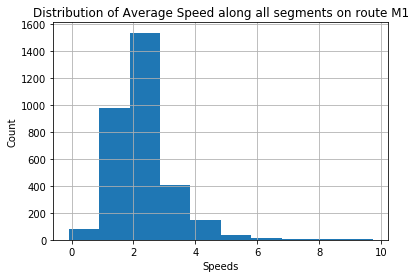

In [54]:
import matplotlib.pyplot as plt
df_avg['AvgSpeed'].hist()
plt.title('Distribution of Average Speed along all segments on route M1')
plt.xlabel('Speeds')
plt.ylabel('Count')
plt.show()

In [55]:
df_avg = df_avg[['NewVehicleRef', 'Timestamp_x', 'segment_id', 'BusLane_x',
                 'DayOfWeek_x', 'Holiday_x', 'HalfHourly', 'timeinseconds',
                 'intersections_x', 'busstops_x', 'AvgSpeed']]

In [56]:
df_avg.head()

,NewVehicleRef,Timestamp_x,segment_id,BusLane_x,DayOfWeek_x,Holiday_x,HalfHourly,timeinseconds,intersections_x,busstops_x,AvgSpeed
0,MTA NYCT_3828_1,2018-04-21 17:32:06.404000-04:00,1,False,6,1,3,63126,11,4,2.297799
1,MTA NYCT_3828_1,2018-04-27 18:38:40.371000-04:00,1,True,5,0,5,67120,11,4,3.013069
2,MTA NYCT_3828_1,2018-05-01 17:02:12.294000-04:00,1,True,2,0,2,61332,11,4,2.941267
3,MTA NYCT_3828_1,2018-04-21 17:37:56.484000-04:00,2,False,6,1,3,63476,15,5,1.005892
4,MTA NYCT_3828_1,2018-04-27 18:42:20.961000-04:00,2,True,5,0,5,67340,15,5,2.848134


In [57]:
df_avg.shape

(3262, 11)

In [58]:
df_avg.to_csv('bus_train.csv', index=False)